# **Analisis Exploratorio de Datos**


Los objetivos del presente proyecto de analisis de datos son:

1. Comprender el comportamiento general del precio del sistema interconectado nacional.
2. Determinar la correlacion del precio con las otras variables del sistema de generación eléctrica.
3. Comprender la influencia de los fenomenos climáticos en el precio del SIN.
4. Encontrar la influencia del consumo de combustible en el precio de la eléctricidad.

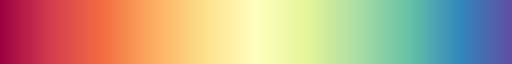

In [116]:
import pandas as pd
import os
import pandas as pd
from sqlalchemy import create_engine
import dotenv
import math
import numpy as np

import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px

sns.set_theme('notebook')
sns.color_palette("Spectral", as_cmap=True)


## Conexión a la Base de Datos de Analítica en AWS

In [117]:
dotenv.load_dotenv("vars.env", override=True)

db_user = os.getenv('DB_USER_AWS')
db_password = os.getenv('DB_PASSWORD_AWS')
db_host = os.getenv('DB_HOST_AWS')
db_port = os.getenv('DB_PORT_AWS')
db_name = os.getenv('DB_NAME_AWS')

conn = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}', echo=False)

## Lectura del DataSet de Analítica

In [118]:
sql_query = """SELECT * FROM analitica_sistema_electrico_colombia"""
df_sistema_electrico = pd.read_sql_query(sql_query, con=conn)
df_sistema_electrico['Date'] = pd.to_datetime(df_sistema_electrico['Date'])
df_sistema_electrico

,Date,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily,disponibilidad_real_daily
0,2010-01-01,1.154191e+08,1.154409e+08,2079352.97,1.000661e+10,0.00000,45616100,75130000,15428396811,1.133616e+08,4536.91,21849.64,120.501228,356.70894,7.278816e+05,1.201925e+07
1,2010-01-02,1.276812e+08,1.276983e+08,2226467.46,9.995147e+09,0.00000,43097100,75130000,15428396811,1.254718e+08,12551.38,17079.39,118.495340,355.06286,7.439290e+05,1.198702e+07
2,2010-01-03,1.236378e+08,1.236548e+08,2509638.35,9.992677e+09,0.00000,43400400,75130000,15428396811,1.211452e+08,9118.35,17032.69,121.160145,355.07299,7.490638e+05,1.199573e+07
3,2010-01-04,1.459575e+08,1.444114e+08,2032914.64,9.965341e+09,0.00000,40410400,75130000,15428396811,1.439317e+08,1513370.10,7174.60,123.962937,355.07299,7.727362e+05,1.158610e+07
4,2010-01-05,1.521480e+08,1.490348e+08,2278901.51,9.926760e+09,0.00000,41190600,75130000,15428396811,1.498691e+08,3057651.95,0.00,120.666437,354.78317,7.674916e+05,1.165207e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5229,2024-04-26,2.246048e+08,2.246048e+08,3468541.50,5.399084e+09,81390.03841,175197100,222790000,17359561885,2.211362e+08,0.00,0.00,215.201028,742.65054,1.077649e+06,1.492237e+07
5230,2024-04-27,2.171655e+08,2.171655e+08,3317765.92,5.454065e+09,72221.14808,190925700,222790000,17359561885,2.138478e+08,0.00,0.00,160.221522,742.65054,9.592092e+05,1.465035e+07
5231,2024-04-28,1.941888e+08,1.941931e+08,2880163.08,5.557993e+09,65899.83428,206187700,222790000,17359561885,1.913129e+08,12438.22,4315.01,106.818940,742.65054,8.649091e+05,1.526666e+07
5232,2024-04-29,2.223545e+08,2.223672e+08,2869374.84,5.672510e+09,50743.73833,303206200,222790000,17359561885,2.194978e+08,41646.96,12662.44,136.110230,742.65054,6.467688e+05,1.529123e+07


In [119]:
df_sistema_electrico = df_sistema_electrico.set_index('Date')

## Exploración del Dataset y sus Variables

In [120]:
df_sistema_electrico.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5234 entries, 2010-01-01 to 2024-04-30
Data columns (total 15 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   generacion_sistema_daily                 5234 non-null   float64
 1   generacion_ideal_sistema_daily           5234 non-null   float64
 2   perdidas_sistema_daily                   5234 non-null   float64
 3   volumen_util_energia_sistema_daily       5234 non-null   float64
 4   emisiones_sistema_daily                  5234 non-null   float64
 5   aportes_energia_sistema_daily            5234 non-null   int64  
 6   aportes_energia_mediaHist_sistema_daily  5234 non-null   int64  
 7   capacidad_util_energia_sistema_daily     5234 non-null   int64  
 8   demanda_real_sistema_daily               5234 non-null   float64
 9   exportaciones_sistema_daily              5234 non-null   float64
 10  importaciones_sistema_daily   

### Descripción de las Variables

A continuación se lista todas las variables disponibles para el analisis.
El dataset continue el valor de la variable por cada dia de operacion del sistema.

| No. | Variable                                | Metrica                               | Unidad | Descripción                                                                                                    | Unidad de Análisis |
|-----|-----------------------------------------|---------------------------------------|--------|----------------------------------------------------------------------------------------------------------------|---------------------|
| 1   | generacion_sistema_daily                | Generación por Sistema                | kWh    | Generación neta de cada una de las plantas Nacionales en sus puntos de frontera.                               | GWh                 |
| 2   | generacion_ideal_sistema_daily          | Generación Ideal por Sistema          | kWh    | Despacho de generación que resulta de considerar una red de transporte inexistente.                             | GWh                 |
| 3   | perdidas_sistema_daily                  | Pérdidas de Energía por Sistema       | kWh    | Cantidad de las inyecciones de energía al Sistema de Transmisión Nacional, menos la cantidad de los flujos... | GWh                 |
| 4   | volumen_util_energia_sistema_daily     | Volumen Útil diario Energía Sistema  | kWh    | Volumen almacenado por encima del Nivel Mínimo Técnico, reportado diariamente por los agentes.                 | GWh                 |
| 5   | emisiones_sistema_daily                 | Emisiones de CO2 por RecursoComb      | TonCO2 | Emisiones totales de Dióxido de Carbono – CO2 de las plantas de generación registradas ante el CND.            | kTonCO2             |
| 6   | aportes_energia_sistema_daily           | Aportes Energía por Río               | kWh    | Caudales en energía de los ríos que aportan agua a algún embalse del SIN.                                       | GWh                 |
| 7   | aportes_energia_mediaHist_sistema_daily| Aportes Media Histórica Energía por Río| kWh    | Caudal medio mensual histórico en energía para los ríos del SIN.                                                | GWh                 |
| 8   | capacidad_util_energia_sistema_daily   | Capacidad Útil Energía por Embalse    | kWh    | Corresponde al Volumen Útil del Embalse, que se define como el volumen almacenado entre el nivel Mínimo Técnico y el Nivel Máximo Físico | GWh                 |
| 9   | demanda_real_sistema_daily             | Demanda Real por sistema              | kWh    | Demanda de usuarios regulados y no regulados que hacen parte del Sistema Interconectado Nacional.               | GWh                 |
| 10  | exportaciones_sistema_daily            | Exportaciones de energía              | kWh    | Transferencias de Energía desde Colombia hacia otros países.                                                    | MWh                 |
| 11  | importaciones_sistema_daily            | Importaciones de energía              | kWh    | Transferencias de Energía desde otros países para abastecer la demanda nacional.                                | MWh                 |
| 12  | precio_bolsa_sistema_daily             | Precio Bolsa Promedio Aritmético      | COP/kWh| Promedio aritmético del precio de bolsa nacional.                                                               | COP/kWh             |
| 13  | precio_escasez_sistema_daily           | Precio Marginal Escasez por Sistema   | COP/kWh| Precio Marginal de Escasez calculado de acuerdo con la Resolución CREG 140 del 2017.                            | COP/kWh             |
| 14  | comsumo_combustible_daily              | Consumo Combustible MBTU por Recurso  | MBTU   | Los generadores térmicos deben reportar diariamente el consumo de combustible en MBTU.                          | MMBTU               |
| 15  | disponibilidad_real_daily              | Disponibilidad Real  | kW   | Disponibilidad promedio calculada a partir de la fecha de los eventos que modifican la disponibilidad de las unidades de generacion de los generadores, asi como de la disponibilidad reportada al Centro de despacho.                       | MW         |

### Conversion de Unidades a las Unidades de Análisis

In [121]:
def convertir_unidades(df): 
    # Crear un diccionario con los factores de conversión
    conversion_factors = {
        'generacion_sistema_daily': 1e-6,  # kWh to GWh
        'generacion_ideal_sistema_daily': 1e-6,  # kWh to GWh
        'perdidas_sistema_daily': 1e-6,  # kWh to GWh
        'volumen_util_energia_sistema_daily': 1e-6,  # kWh to GWh
        'emisiones_sistema_daily': 1e-3,  # TonCO2 to kTonCO2
        'aportes_energia_sistema_daily': 1e-6,  # kWh to GWh
        'aportes_energia_mediaHist_sistema_daily': 1e-6,  # kWh to GWh
        'capacidad_util_energia_sistema_daily': 1e-6,  # kWh to GWh
        'demanda_real_sistema_daily': 1e-6,  # kWh to GWh
        'exportaciones_sistema_daily': 1e-3,  # kWh to MWh
        'importaciones_sistema_daily': 1e-3,  # kwh to MWh
        'precio_bolsa_sistema_daily': 1,  # COP/kWh to COP/kWh (no conversion needed)
        'precio_escasez_sistema_daily': 1,  # COP/kWh to COP/kWh (no conversion needed)
        'comsumo_combustible_daily': 1e-3,  # MBTU to MMBTU
        'disponibilidad_real_daily': 1e-3,  # kWh to MWh
    }

    # Aplicar las conversiones
    for column, factor in conversion_factors.items():
        df[column] = df[column] * factor

    # Mostrar el DataFrame convertido
    return df

In [122]:
df_sistema_electrico_converted = df_sistema_electrico.copy()
df_sistema_electrico_converted = convertir_unidades(df_sistema_electrico_converted)
df_sistema_electrico_converted

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily,disponibilidad_real_daily
Date,,,,,,,,,,,,,,,
2010-01-01,115.419084,115.440934,2.079353,10006.614779,0.000000,45.6161,75.13,15428.396811,113.361581,4.53691,21.84964,120.501228,356.70894,727.881567,12019.253333
2010-01-02,127.681195,127.698274,2.226467,9995.146811,0.000000,43.0971,75.13,15428.396811,125.471807,12.55138,17.07939,118.495340,355.06286,743.929011,11987.024167
2010-01-03,123.637778,123.654811,2.509638,9992.677303,0.000000,43.4004,75.13,15428.396811,121.145173,9.11835,17.03269,121.160145,355.07299,749.063827,11995.728333
2010-01-04,145.957459,144.411382,2.032915,9965.341214,0.000000,40.4104,75.13,15428.396811,143.931719,1513.37010,7.17460,123.962937,355.07299,772.736247,11586.104167
2010-01-05,152.148029,149.034819,2.278902,9926.759570,0.000000,41.1906,75.13,15428.396811,149.869128,3057.65195,0.00000,120.666437,354.78317,767.491641,11652.071667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,224.604764,224.604764,3.468542,5399.083900,81.390038,175.1971,222.79,17359.561885,221.136223,0.00000,0.00000,215.201028,742.65054,1077.648732,14922.365750
2024-04-27,217.165537,217.165537,3.317766,5454.064900,72.221148,190.9257,222.79,17359.561885,213.847772,0.00000,0.00000,160.221522,742.65054,959.209242,14650.352500
2024-04-28,194.188787,194.193102,2.880163,5557.993200,65.899834,206.1877,222.79,17359.561885,191.312939,12.43822,4.31501,106.818940,742.65054,864.909070,15266.665000


## Estadistica Descriptiva


### Estadisticos del Dataset

In [123]:
df_sistema_electrico_converted.describe()

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily,disponibilidad_real_daily
count,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000,5234.000000
mean,185.062136,185.175181,2.800156,10866.323553,14.180502,162.732899,167.408424,16494.452831,183.253813,1731.938017,991.816631,225.569533,499.731301,381.504848,12891.569094
std,22.842767,22.883043,0.568683,2412.985776,18.506221,79.487528,49.623124,932.983913,22.869576,2978.019699,2152.138271,205.734350,182.292409,172.910657,1201.738775
min,115.419084,115.440934,-2.118570,4958.518300,0.000000,29.032100,69.770000,15097.508374,113.361581,0.000000,0.000000,35.356673,289.787340,113.521375,8850.326083
25%,168.157388,168.207475,2.432048,9258.527770,0.000000,104.724325,127.120000,15428.396811,166.184080,4.538617,0.865135,106.351090,363.176550,249.152440,11991.579583
50%,184.299340,184.529427,2.753888,11088.633250,0.000000,149.289550,177.260000,16920.877858,182.850101,39.605140,11.467630,158.982260,449.830580,340.935961,12975.459625
75%,199.077388,199.330480,3.118325,12777.188541,24.442364,205.474700,206.670000,17197.713215,198.366957,2418.663413,374.573627,247.326889,555.401030,476.947453,13803.071729
max,250.439131,250.439131,7.079952,15649.798000,83.577438,591.245300,280.040000,18237.183030,246.937412,35052.391050,10911.030180,1942.692797,1037.232360,1104.847110,16699.097167


### Visualización de las distribuiciones de las variables

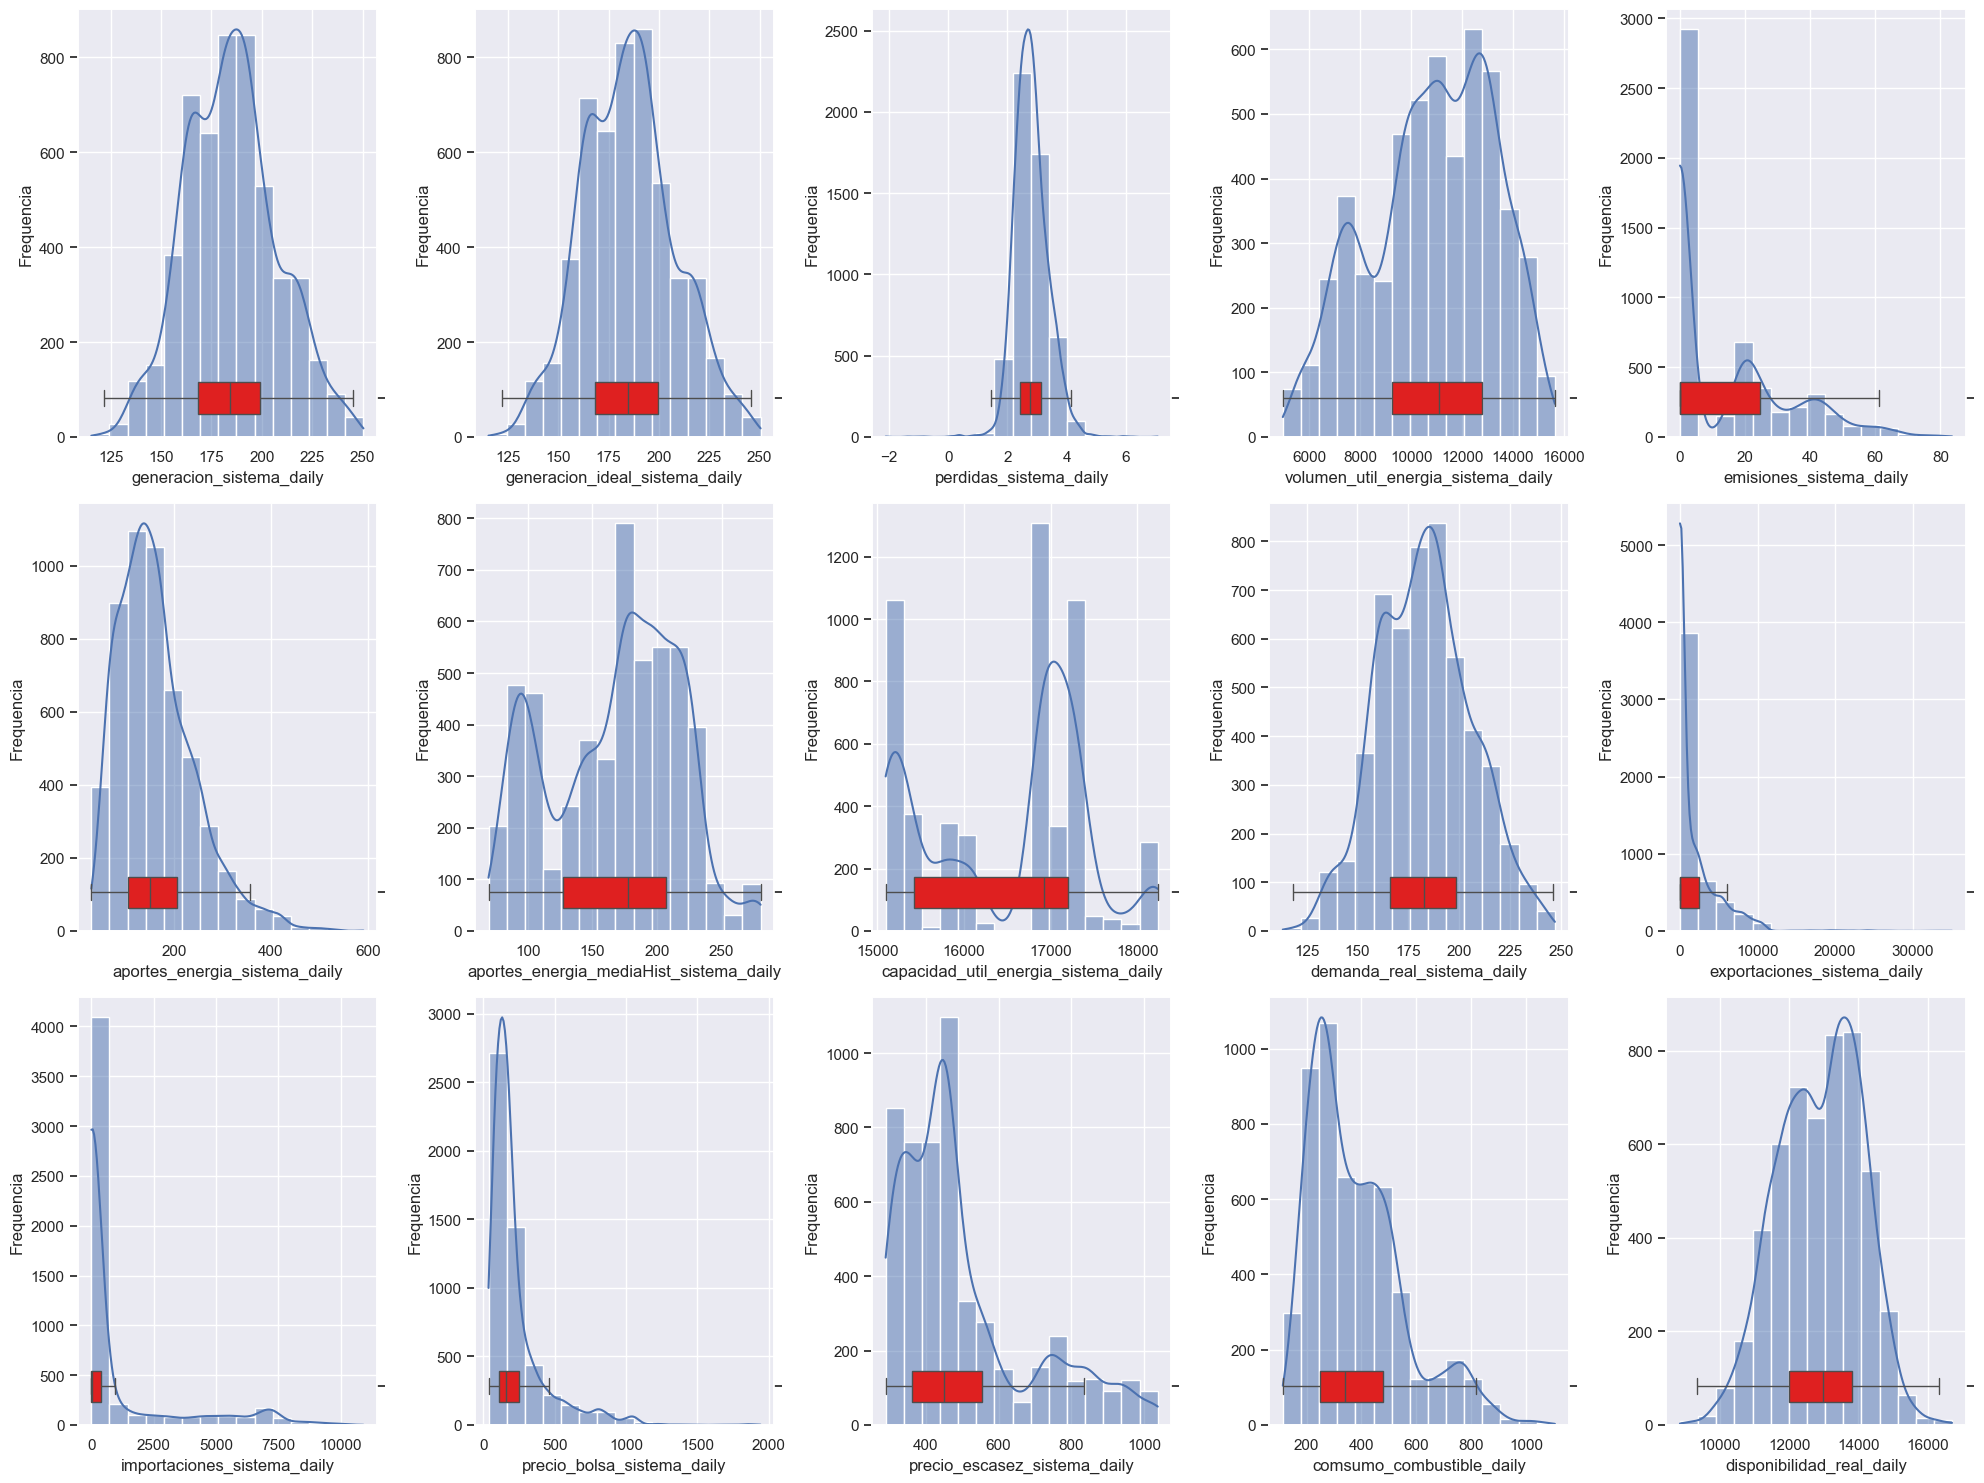

In [124]:
# Modificar la función para aceptar un objeto Axes
def plot_distribution(ax, df, column, xlabel, ylabel, title):
    # Histograma de distribución
    hist = sns.histplot(data=df[column], kde=True, bins=15, ax=ax)
    hist.set_xlabel(xlabel)
    hist.set_ylabel(ylabel)
    hist.set_title(title)

    # Boxplot superpuesto
    dist_box = ax.twinx()
    sns.boxplot(x=df[column], ax=dist_box, color='red', showfliers=False)
    dist_box.set(ylim=(-1, 10))

# Nueva función para crear subplots
def plot_all_distributions(df):
    num_columns = len(df.columns)
    num_rows = 3
    num_cols = math.ceil(num_columns / num_rows)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = axes.flatten()  # Aplanar el array de ejes para un fácil acceso

    for i, column in enumerate(df.columns):
        xlabel = column
        ylabel = 'Frequencia'
        title = ''
        plot_distribution(axes[i], df, column, xlabel, ylabel, title)
    
    # Eliminar los ejes vacíos si el número de subplots no es múltiplo de num_rows
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_all_distributions(df_sistema_electrico_converted)

## Visualizacion de Series de Tiempo

Con el fin de encontrar datos anómalos realizaremos construiremos varias gráficas de las variables vs el tiempo.

In [125]:
def plot_time_series(df, columns_to_plot, titulo, unidades):
    """
    Esta función genera un gráfico de línea de tiempo para las columnas especificadas en un DataFrame.

    :param df: pandas DataFrame que contiene los datos a graficar.
    :param columns_to_plot: lista de columnas del DataFrame que se desean graficar.
    """
    # Verificar que el índice del DataFrame sea de tipo datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("El índice del DataFrame debe ser de tipo datetime")

    # Verificar que las columnas a graficar estén en el DataFrame
    for column in columns_to_plot:
        if column not in df.columns:
            raise ValueError(f"La columna '{column}' no está en el DataFrame")
    
    plt.figure(figsize=(12, 6), dpi=200)
    
    for column in columns_to_plot:
        sns.lineplot(data=df, x=df.index, y=column, label=column)

    plt.xlabel('Fecha')
    plt.ylabel(unidades)
    plt.title(titulo)
    plt.legend()
    plt.grid(True)
    plt.show()

## Variables de Energía

In [126]:
df_sistema_electrico_converted.columns

Index(['generacion_sistema_daily', 'generacion_ideal_sistema_daily',
       'perdidas_sistema_daily', 'volumen_util_energia_sistema_daily',
       'emisiones_sistema_daily', 'aportes_energia_sistema_daily',
       'aportes_energia_mediaHist_sistema_daily',
       'capacidad_util_energia_sistema_daily', 'demanda_real_sistema_daily',
       'exportaciones_sistema_daily', 'importaciones_sistema_daily',
       'precio_bolsa_sistema_daily', 'precio_escasez_sistema_daily',
       'comsumo_combustible_daily', 'disponibilidad_real_daily'],
      dtype='object')

### Generación y Demanda

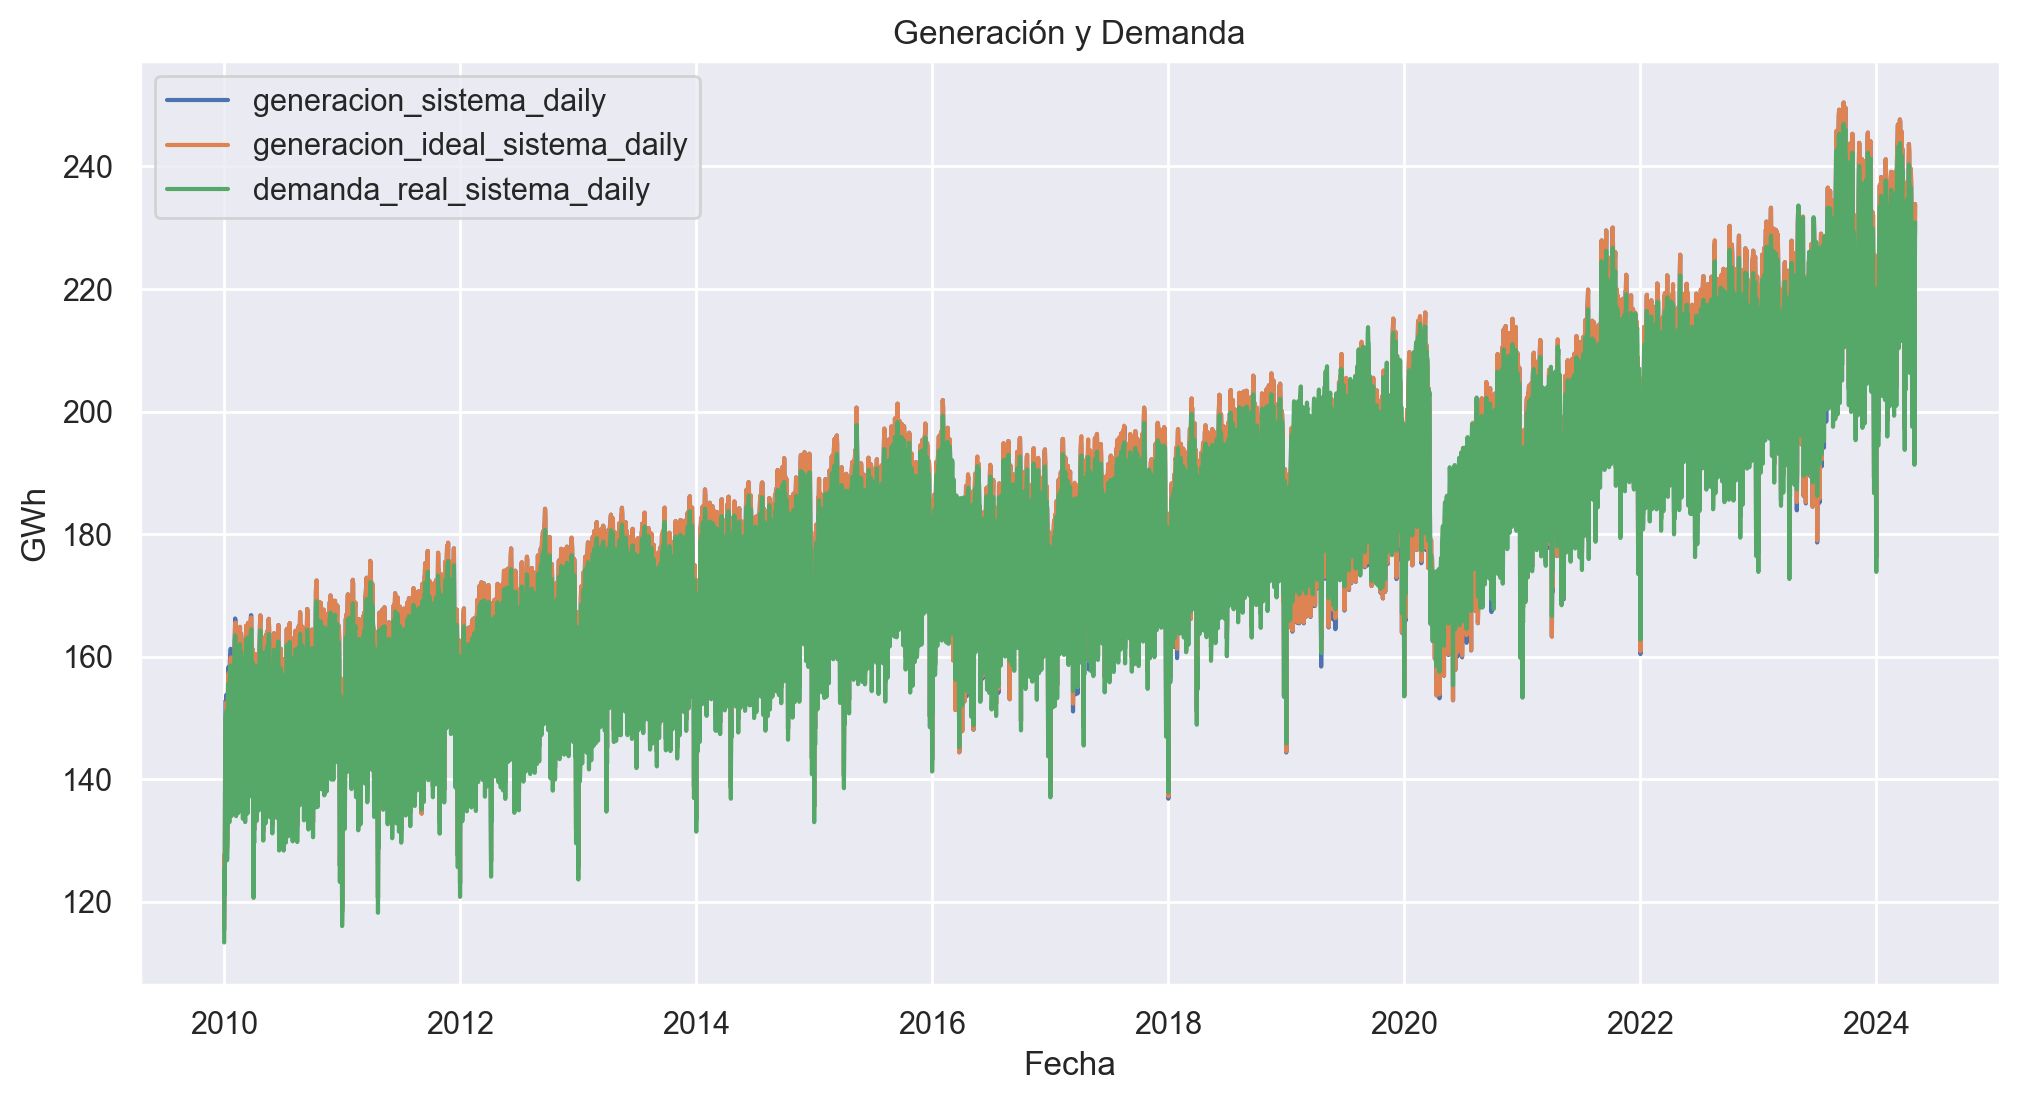

In [127]:
plot_time_series(df_sistema_electrico_converted, ['generacion_sistema_daily',
                                                  'generacion_ideal_sistema_daily',
                                                  'demanda_real_sistema_daily',
                                                  ], 'Generación y Demanda', 'GWh')

### Perdidas de Energía del Sistema

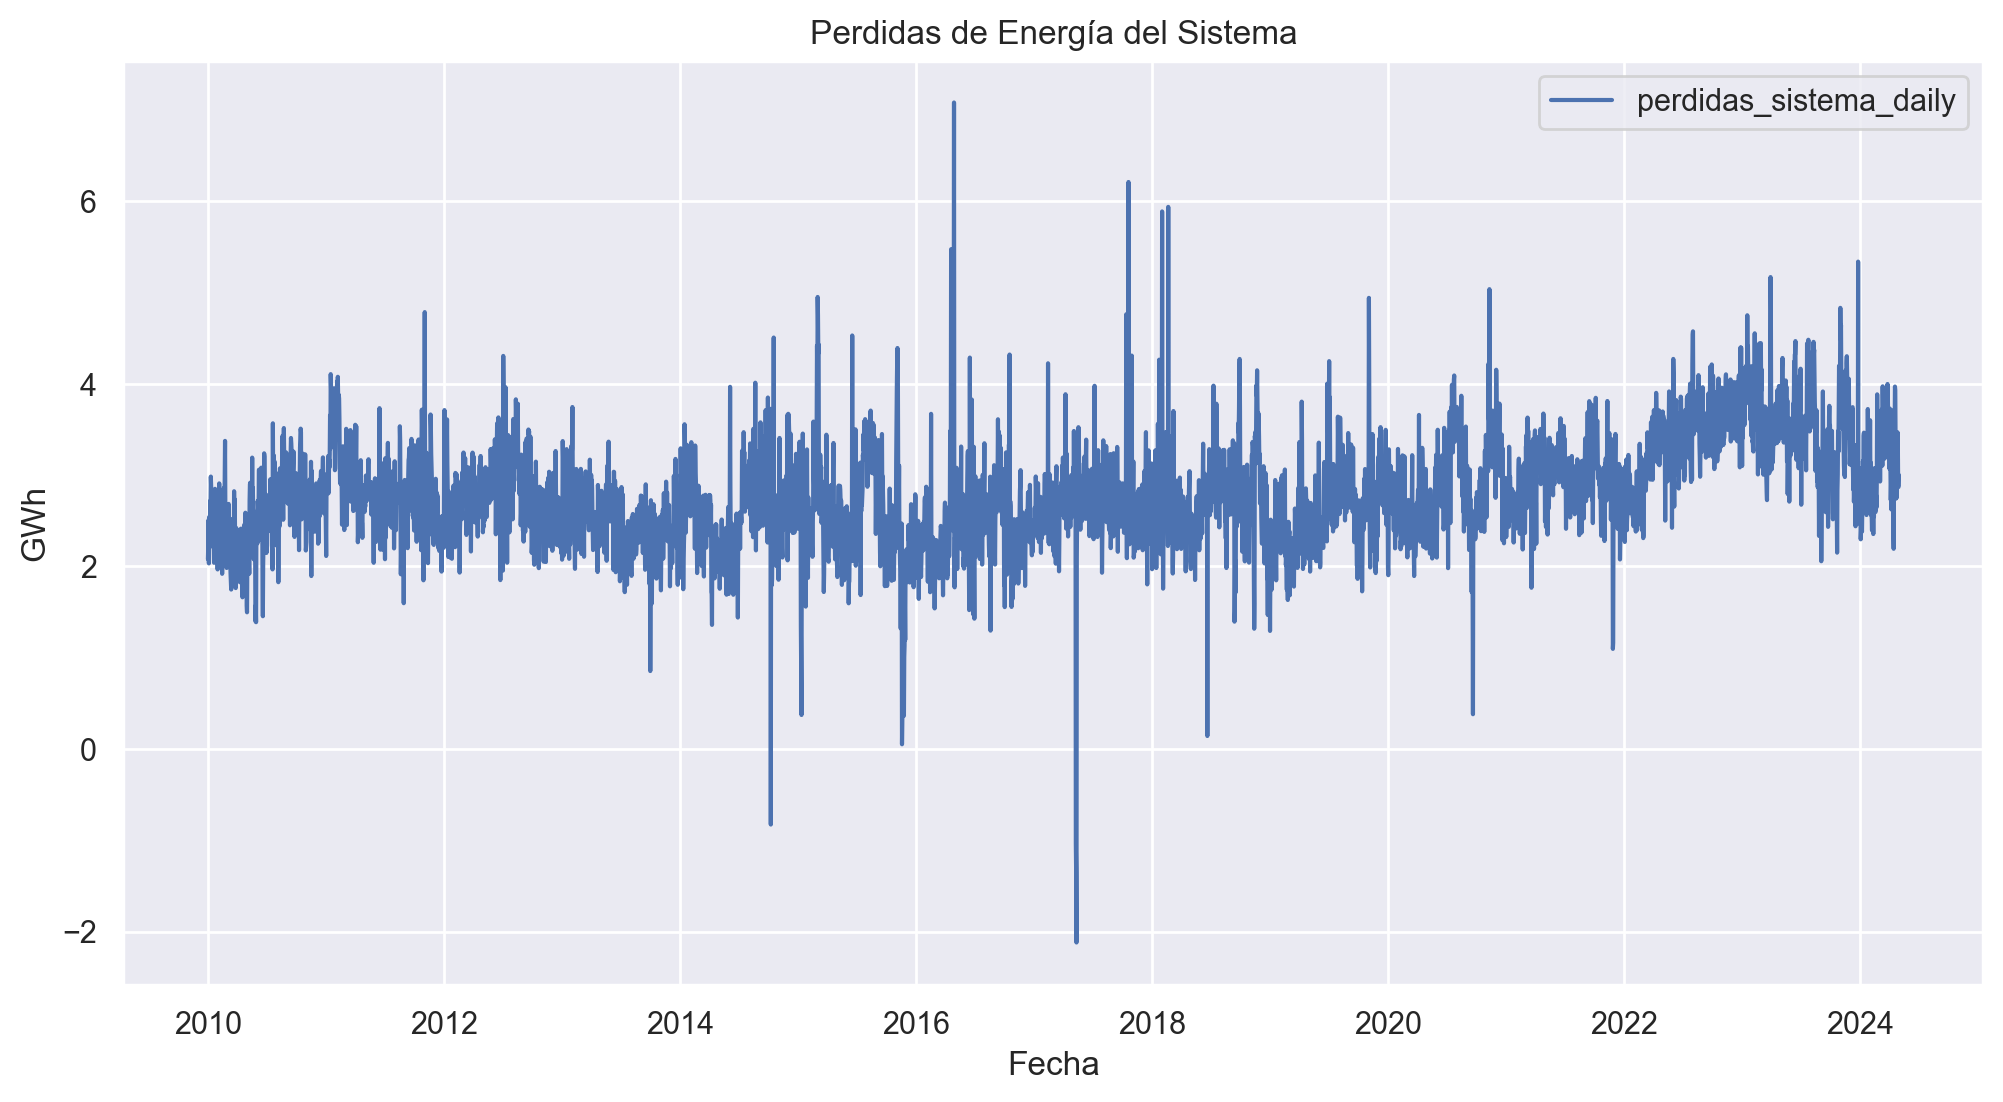

In [128]:
plot_time_series(df_sistema_electrico_converted, ['perdidas_sistema_daily'], 'Perdidas de Energía del Sistema', 'GWh')

### Aportes de Energía por Lluvia vs Media Historica de Aportes

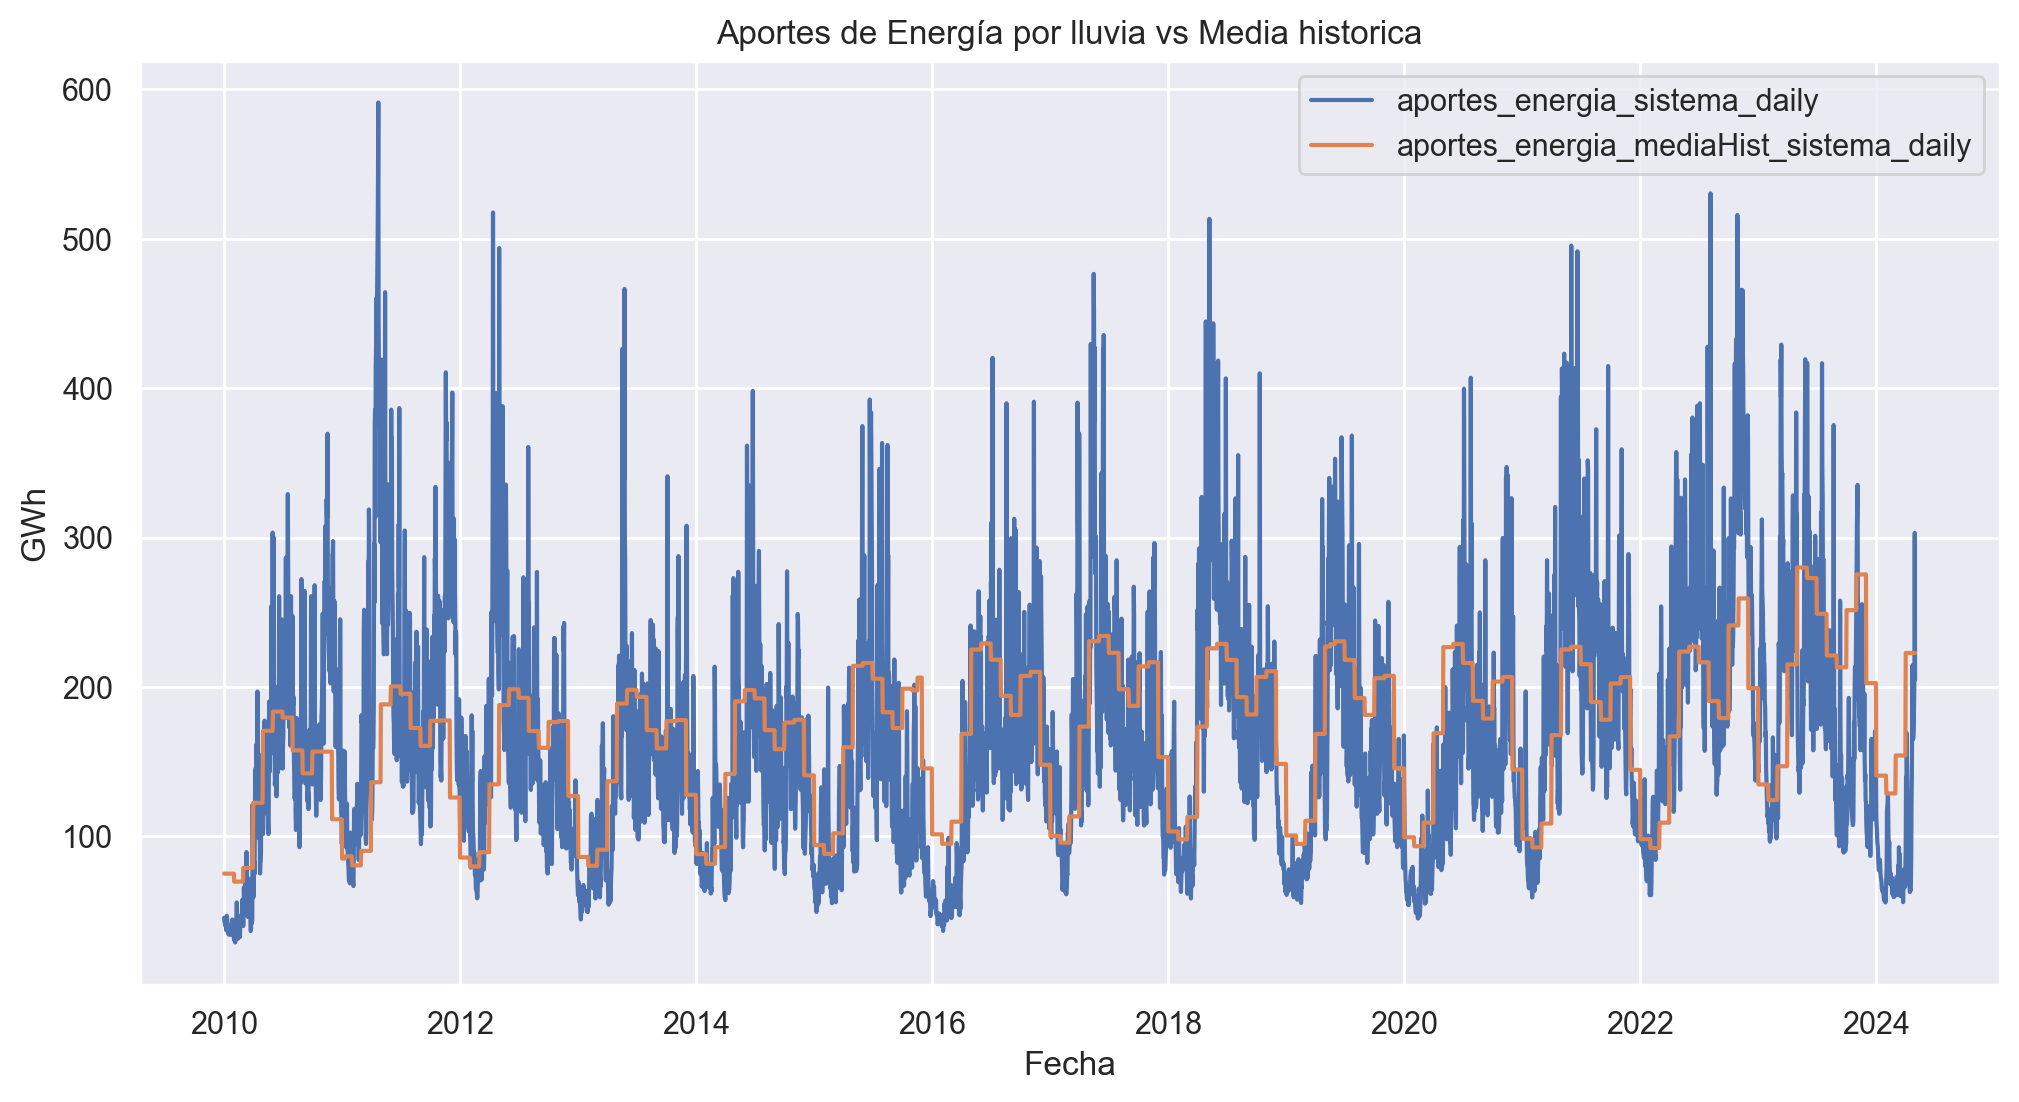

In [129]:
plot_time_series(df_sistema_electrico_converted, ['aportes_energia_sistema_daily', 'aportes_energia_mediaHist_sistema_daily'], 'Aportes de Energía por lluvia vs Media historica', 'GWh')

### Capacidad y Volumen Util del Sistema

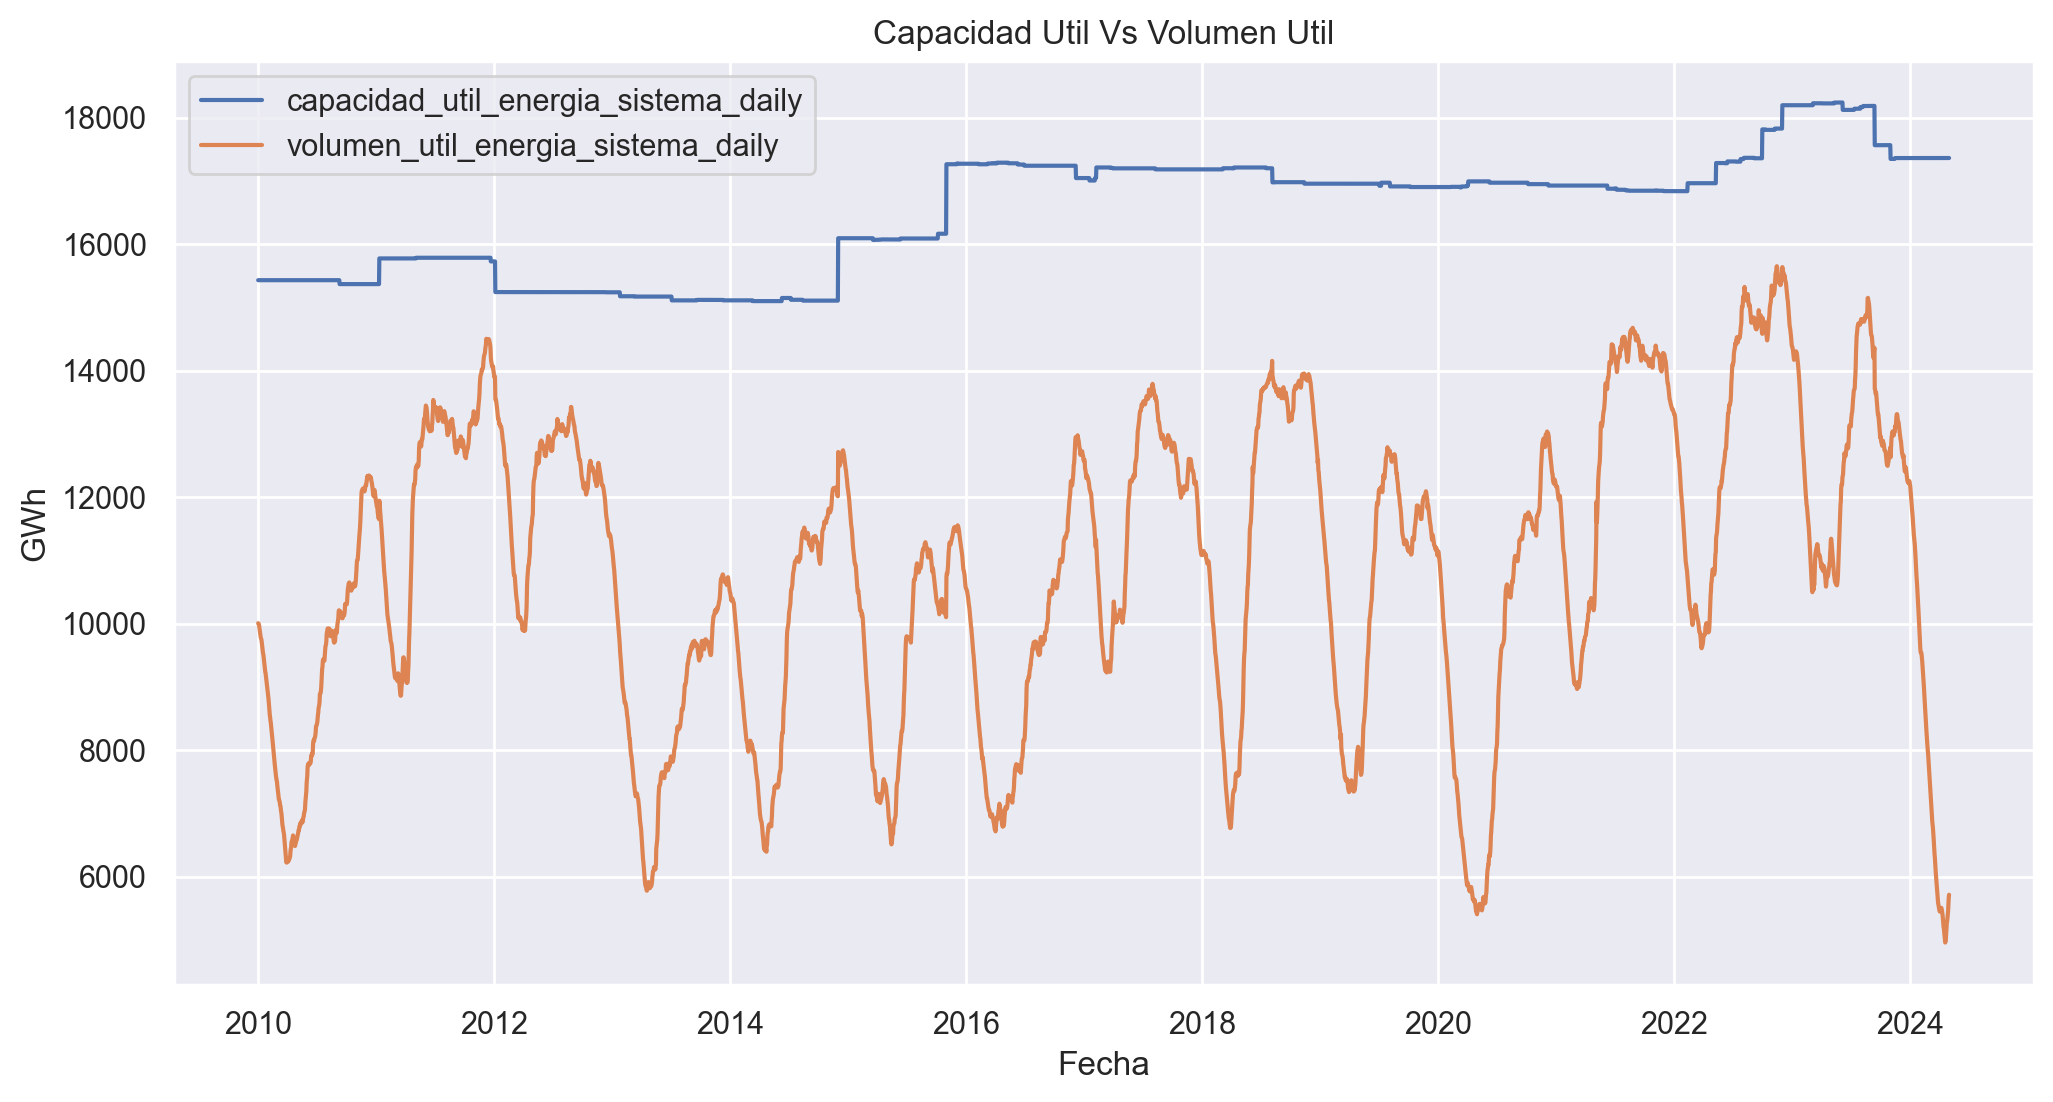

In [130]:
plot_time_series(df_sistema_electrico_converted, ['capacidad_util_energia_sistema_daily', 
                                                  'volumen_util_energia_sistema_daily'], 
                                                  'Capacidad Util Vs Volumen Util', 'GWh')

In [131]:
df_sistema_electrico_converted['volumen_util_energia_sistema_daily'].idxmin()

Timestamp('2024-04-18 00:00:00')

### Disponibilidad Real

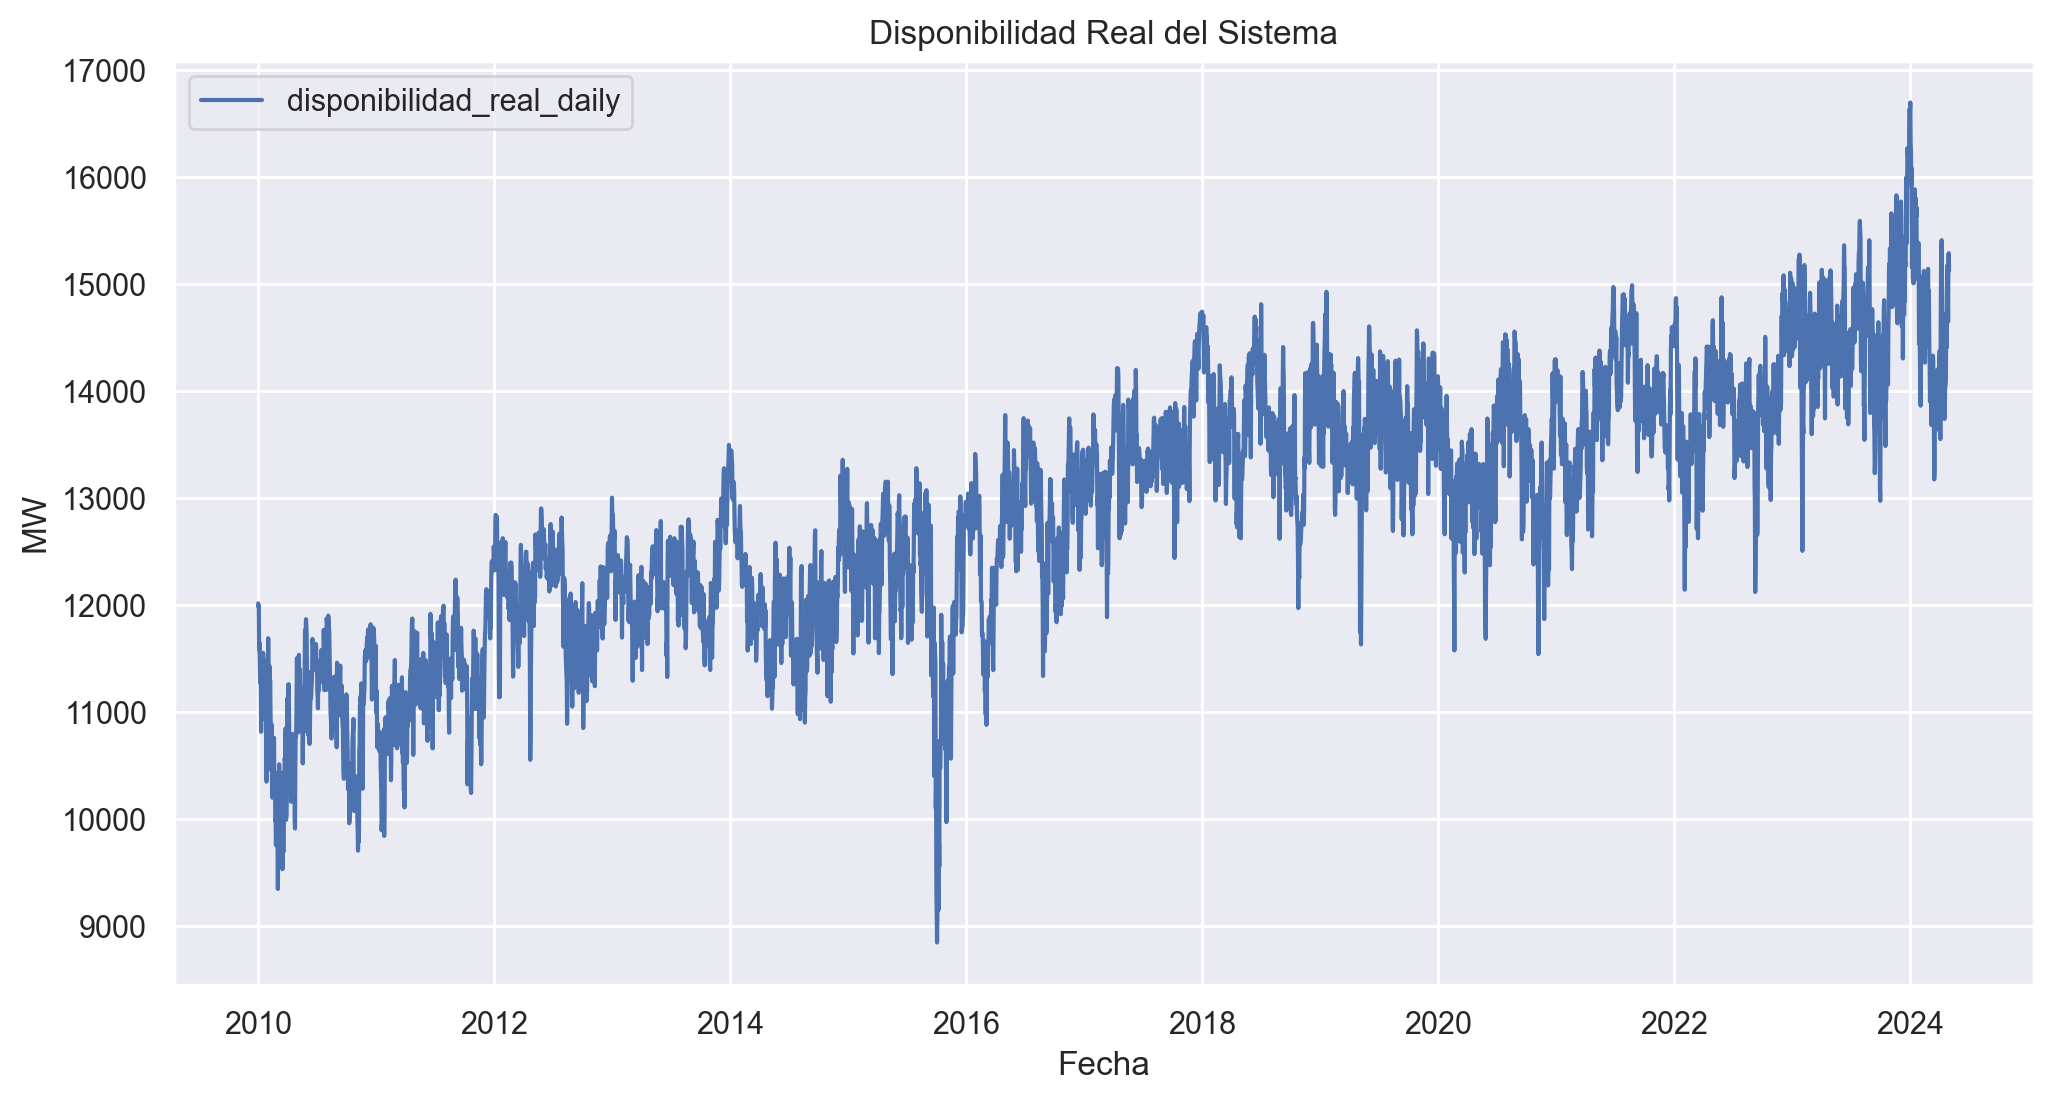

In [132]:
plot_time_series(df_sistema_electrico_converted, ['disponibilidad_real_daily'], 'Disponibilidad Real del Sistema', 'MW')

### Consumo de Combustible de las Plantas Térmicas

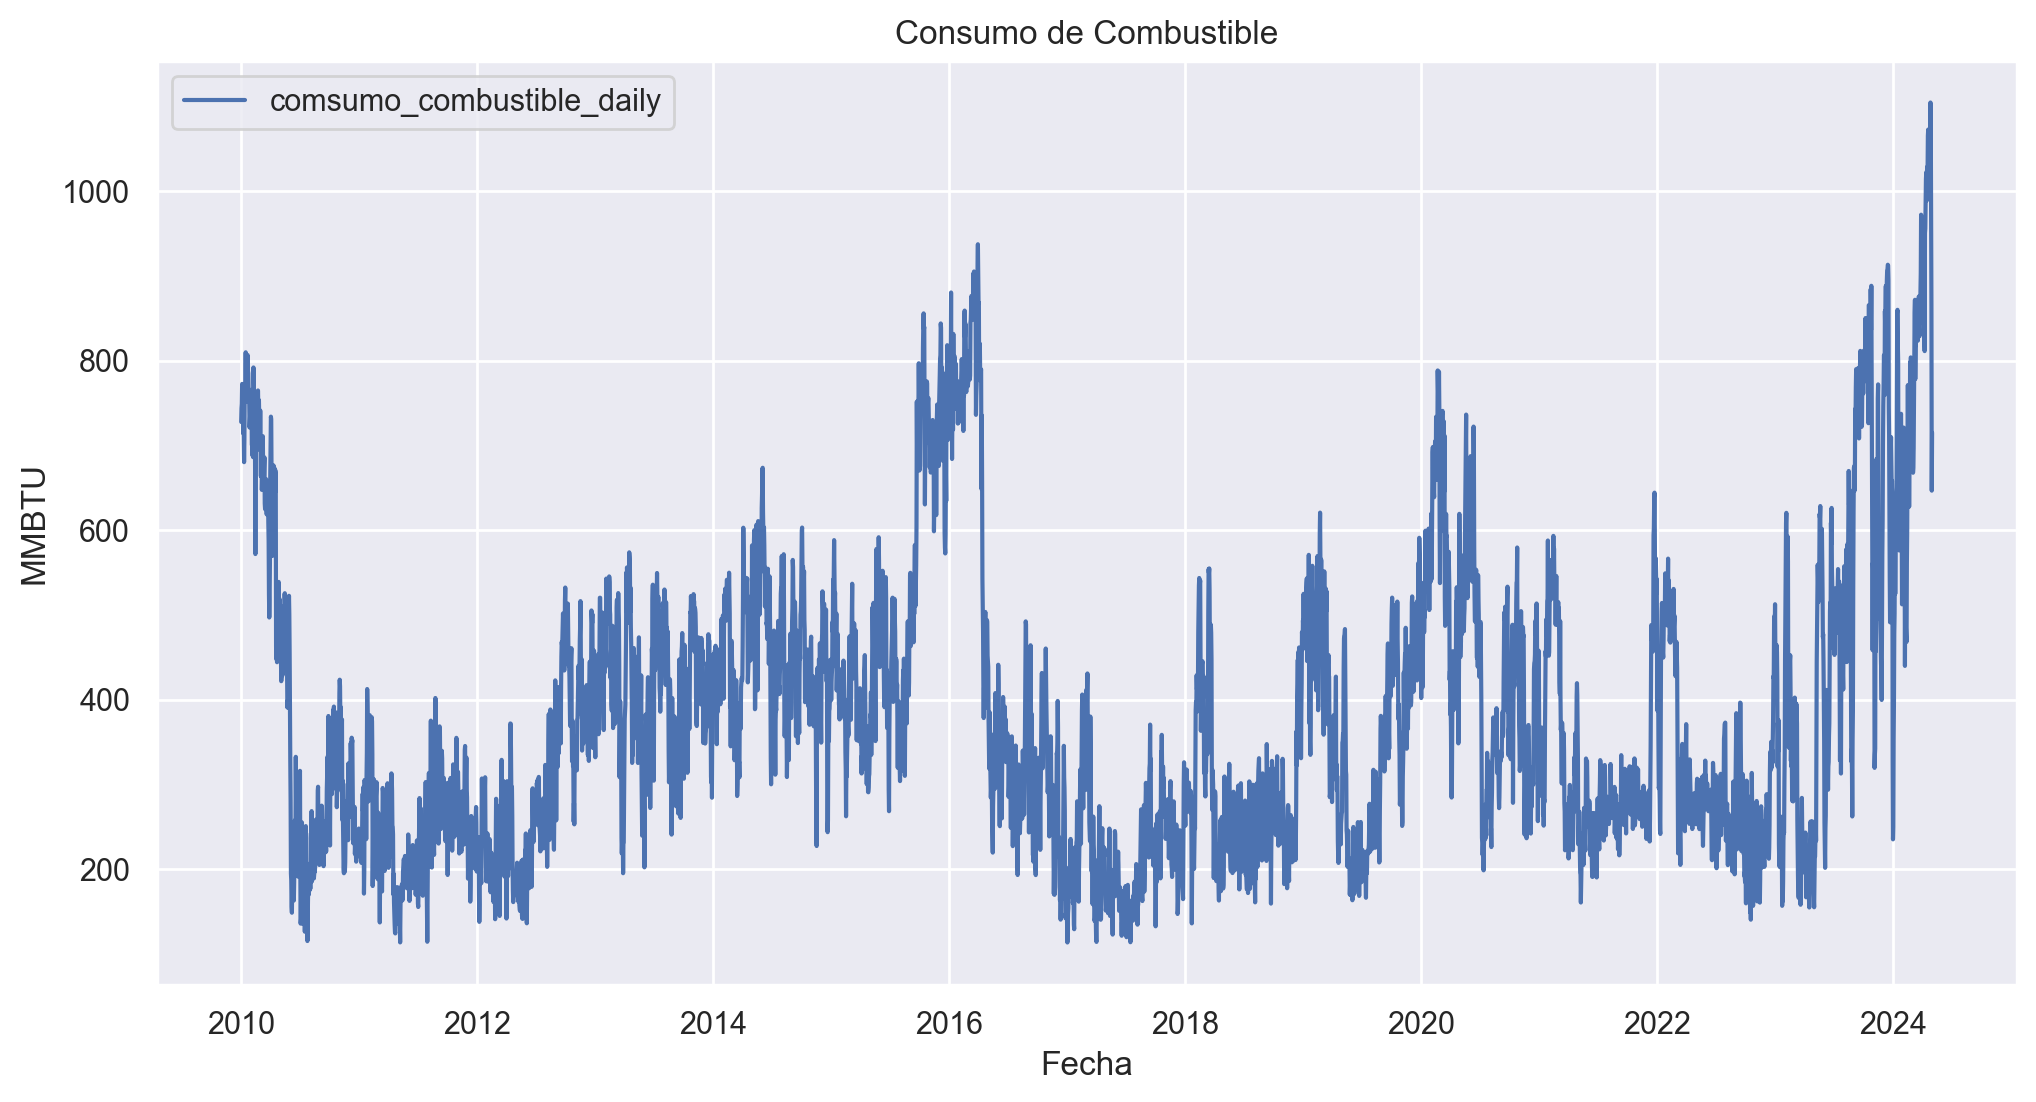

In [133]:
plot_time_series(df_sistema_electrico_converted, ['comsumo_combustible_daily'], 'Consumo de Combustible', 'MMBTU')

### Precio Bolsa Nacional y Precio de Escasez

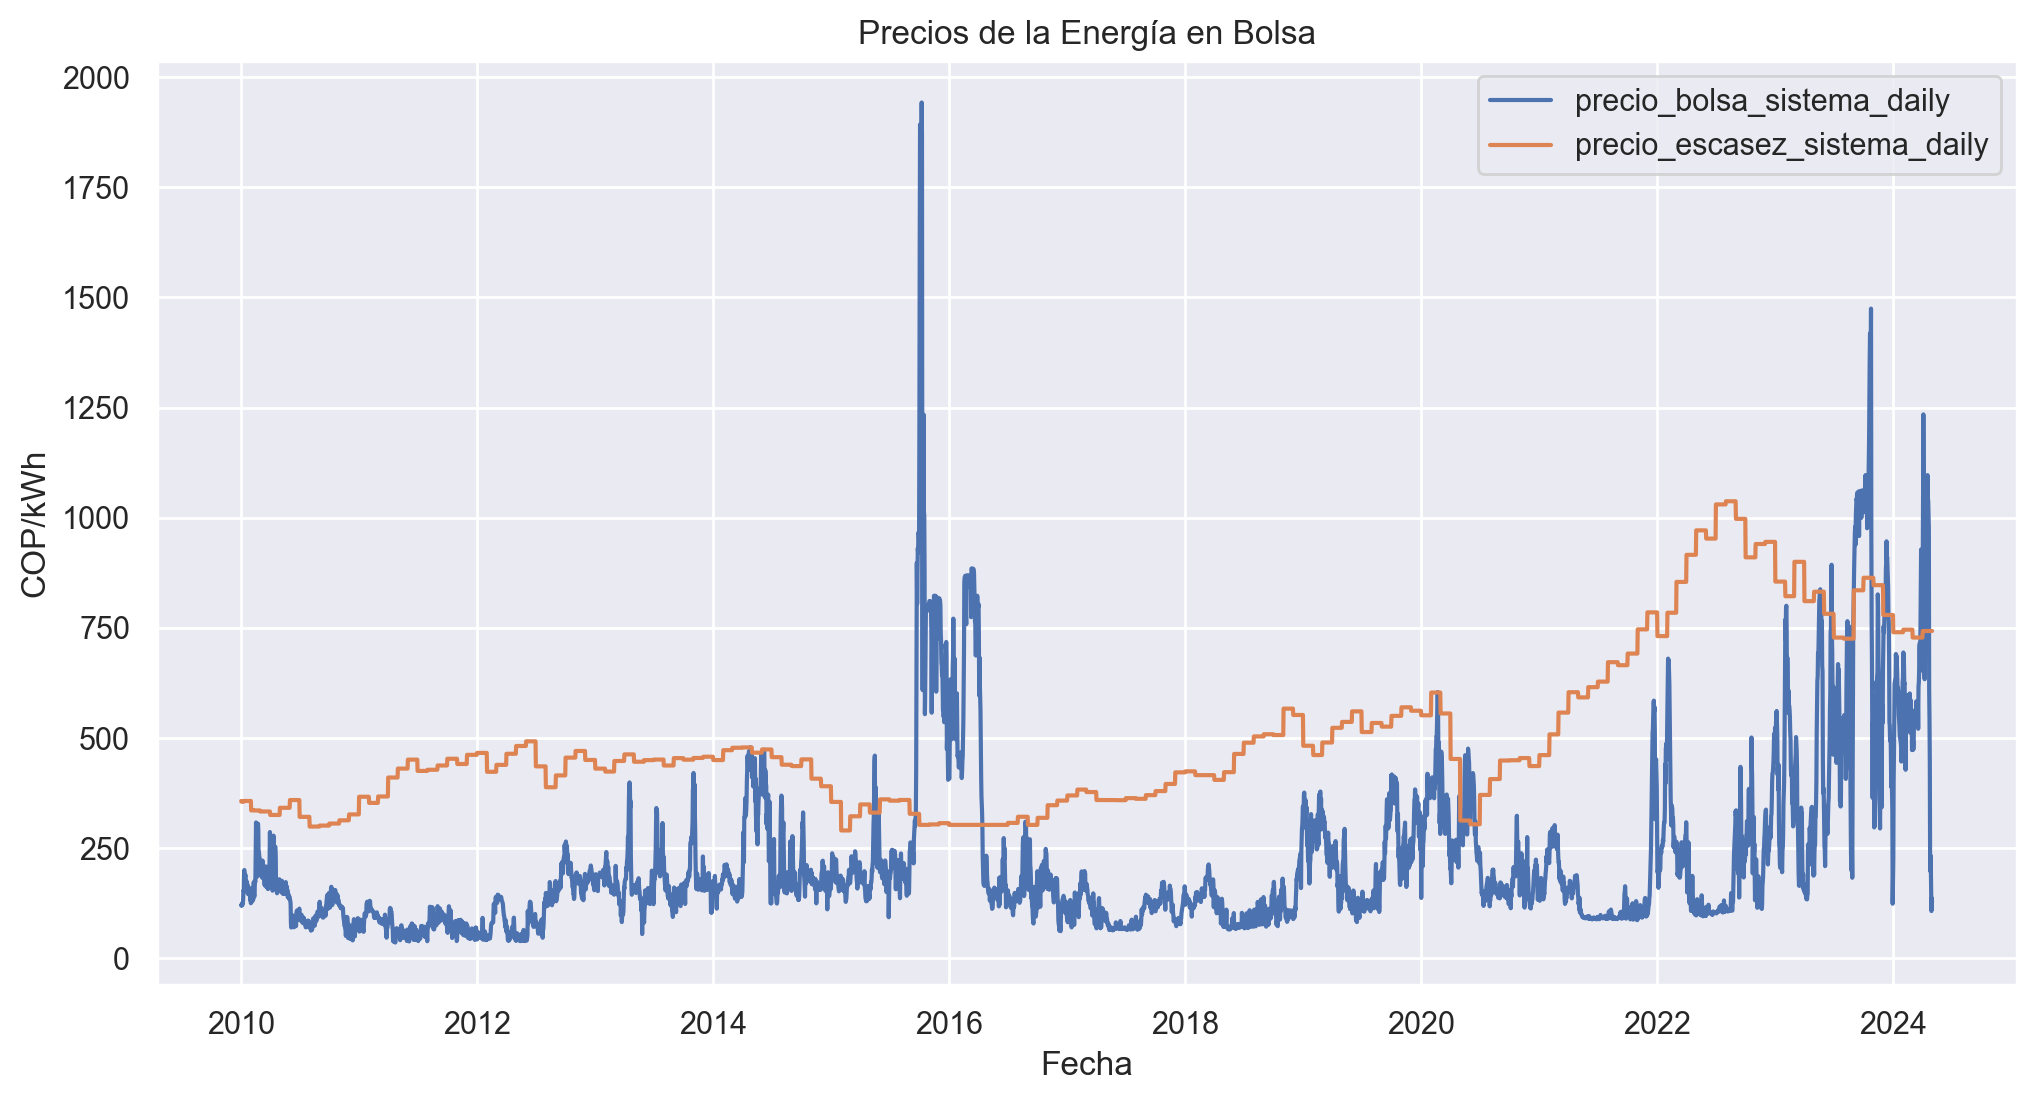

In [134]:
plot_time_series(df_sistema_electrico_converted, ['precio_bolsa_sistema_daily', 'precio_escasez_sistema_daily'], 'Precios de la Energía en Bolsa', 'COP/kWh')

## Análisis de Series Temporales

1. Se observa una anomalía significativa en el Sistema Interconectado Nacional (SIN) durante el cuarto trimestre de 2015 y el primer trimestre de 2016, la cual será analizada en detalle más adelante.
   
2. La generación y demanda actual muestran una tendencia ligeramente positiva a lo largo del intervalo de tiempo, con dos puntos donde la tendencia se invierte localmente: en el cambio de año 2015-2016 y a principios de 2020.
   
3. La disponibilidad real presenta una tendencia levemente positiva de 2013 a 2018, con un marcado descenso en el cambio de año 2014-2015 y a finales de 2015. También se observa una inversión de la tendencia a levemente negativa desde 2018 hasta mediados de 2020.
   
4. Los aportes de energía y el volumen útil muestran un comportamiento estacional claro, con mínimos de todo el perido analizado ubicado en 18/Abril/2024
   
5. El precio parece seguir un comportamiento de series temporales estacionarias a lo largo del intervalo de tiempo analizado.
   
6. Se evidencia una correlación entre las variables que afectan las emisiones, donde incluso las gráficas son muy similares en las características fuertemente correlacionadas. Se recomienda revisar la gráfica de Emisiones $CO_2eq$, Precio y Consumo de Combustible.

### Análisis de 2010 a principios de 2015

Durante este período, se observaron tres importantes reducciones en la disponibilidad real, lo que provocó un aumento en el precio y las emisiones.

La reducción en la disponibilidad puede elevar el precio debido a la menor cantidad de plantas de energía capaces de satisfacer la demanda del sistema, lo que resulta en una menor oferta y una demanda constante o creciente.

Además, si la reducción en la disponibilidad se debe al fallo de una central hidroeléctrica, las centrales térmicas deben aumentar su generación a un costo más alto, lo que conlleva la producción de emisiones contaminantes.

### Análisis del final de 2015 e inicios de 2016

Este período es especialmente interesante ya que las variables muestran un comportamiento muy distinto entre octubre de 2015 y abril de 2016.

Durante este lapso, se observaron varios máximos y mínimos en todo el intervalo temporal de 2013.10.01 a 2021.01.04:

- El pico más alto de emisiones.
- El mayor consumo de combustible fósil.
- El precio más elevado.
- Los menores aportes de energía (agua).
- La disponibilidad promedio más baja (para este análisis, se consideraron atípicos los valores mínimos de 2013 y 2014, excluyéndolos).

Estas cifras difieren notablemente de los otros años debido a la intensidad del Fenómeno del Niño ocurrido en ese periodo.

#### Principales efectos del Fenómeno del Niño en el SIN

Las emisiones, el precio y el consumo de combustible se vieron fuertemente afectados, alcanzando valores máximos durante este período.

Las razones detrás de este comportamiento incluyen:

- La declaración oficial del Fenómeno del Niño a principios de octubre generó especulaciones en el mercado.
- Varias centrales hidroeléctricas detuvieron o redujeron su operación para conservar agua, lo que llevó a que las centrales de gas natural y carbón operaran a máxima capacidad, aumentando así el consumo de combustibles fósiles más costosos.
- La estrategia de conservación de agua provocó una disminución en la disponibilidad promedio.

- Durante los primeros meses del Fenómeno del Niño (de octubre a diciembre), se observó un aumento en el volumen útil junto con una disminución en los aportes de agua, lo cual se explica por la estrategia de conservación de agua.

A pesar de los altos precios y emisiones de $CO_2$, el sistema demostró su capacidad para gestionar este tipo de eventos, equilibrando la generación hidroeléctrica y térmica, y ejecutando una estrategia efectiva de ahorro energético sin necesidad de racionamientos.

### Análisis del año 2020

El año 2020 fue especialmente desafiante debido a la pandemia de coronavirus, que tuvo un impacto sin precedentes en todo el mundo.

A finales de marzo, Colombia implementó una cuarentena estricta que duró más de seis meses.

Abril fue el mes más difícil, con muchas empresas deteniendo sus operaciones.

Este parón económico se refleja claramente en la demanda y generación de energía durante este mes, lo que indica que el sector industrial es un gran consumidor de electricidad, incluso con la población en casa durante todo el día, el consumo residencial no pudo igualar el de la industria.


## Análisis de Correlaciones

En esta sección usaremos el analisis de correlaciones para encontrar las variables que afectan las **emisiones equivalentes de $CO_2$**.

Como nuestros datos puede tener *outliers* usaremos el método de **Spearman**

In [135]:
corr_matrix = df_sistema_electrico_converted.corr(method='pearson')
corr_matrix

,generacion_sistema_daily,generacion_ideal_sistema_daily,perdidas_sistema_daily,volumen_util_energia_sistema_daily,emisiones_sistema_daily,aportes_energia_sistema_daily,aportes_energia_mediaHist_sistema_daily,capacidad_util_energia_sistema_daily,demanda_real_sistema_daily,exportaciones_sistema_daily,importaciones_sistema_daily,precio_bolsa_sistema_daily,precio_escasez_sistema_daily,comsumo_combustible_daily,disponibilidad_real_daily
generacion_sistema_daily,1.000000,0.999768,0.461619,0.259800,0.646242,0.068179,0.313355,0.661634,0.995336,-0.004122,0.084868,0.418816,0.671560,0.224980,0.660278
generacion_ideal_sistema_daily,0.999768,1.000000,0.461464,0.258758,0.646845,0.069873,0.314386,0.664832,0.995822,-0.007202,0.092449,0.417140,0.670537,0.221190,0.662953
perdidas_sistema_daily,0.461619,0.461464,1.000000,0.332935,0.240055,0.194725,0.197856,0.294752,0.439333,0.226099,0.033179,0.012047,0.475243,-0.158628,0.303487
volumen_util_energia_sistema_daily,0.259800,0.258758,0.332935,1.000000,0.029644,0.347088,0.311453,0.251109,0.231766,0.130644,-0.206678,-0.149881,0.410333,-0.415372,0.299882
emisiones_sistema_daily,0.646242,0.646845,0.240055,0.029644,1.000000,-0.081158,0.144195,0.589859,0.676538,-0.098608,0.393408,0.457023,0.571034,0.379389,0.633677
aportes_energia_sistema_daily,0.068179,0.069873,0.194725,0.347088,-0.081158,1.000000,0.550461,0.162061,0.060139,0.026345,-0.033132,-0.288118,0.232550,-0.486544,0.163032
aportes_energia_mediaHist_sistema_daily,0.313355,0.314386,0.197856,0.311453,0.144195,0.550461,1.000000,0.358945,0.315293,-0.087698,0.076781,0.071987,0.264394,-0.181656,0.337325
capacidad_util_energia_sistema_daily,0.661634,0.664832,0.294752,0.251109,0.589859,0.162061,0.358945,1.000000,0.680469,-0.238490,0.286276,0.326368,0.476325,0.031178,0.746224
demanda_real_sistema_daily,0.995336,0.995822,0.439333,0.231766,0.676538,0.060139,0.315293,0.680469,1.000000,-0.034404,0.178048,0.429897,0.662346,0.236426,0.674758
exportaciones_sistema_daily,-0.004122,-0.007202,0.226099,0.130644,-0.098608,0.026345,-0.087698,-0.238490,-0.034404,1.000000,-0.262095,0.016736,0.066092,0.007928,-0.210137


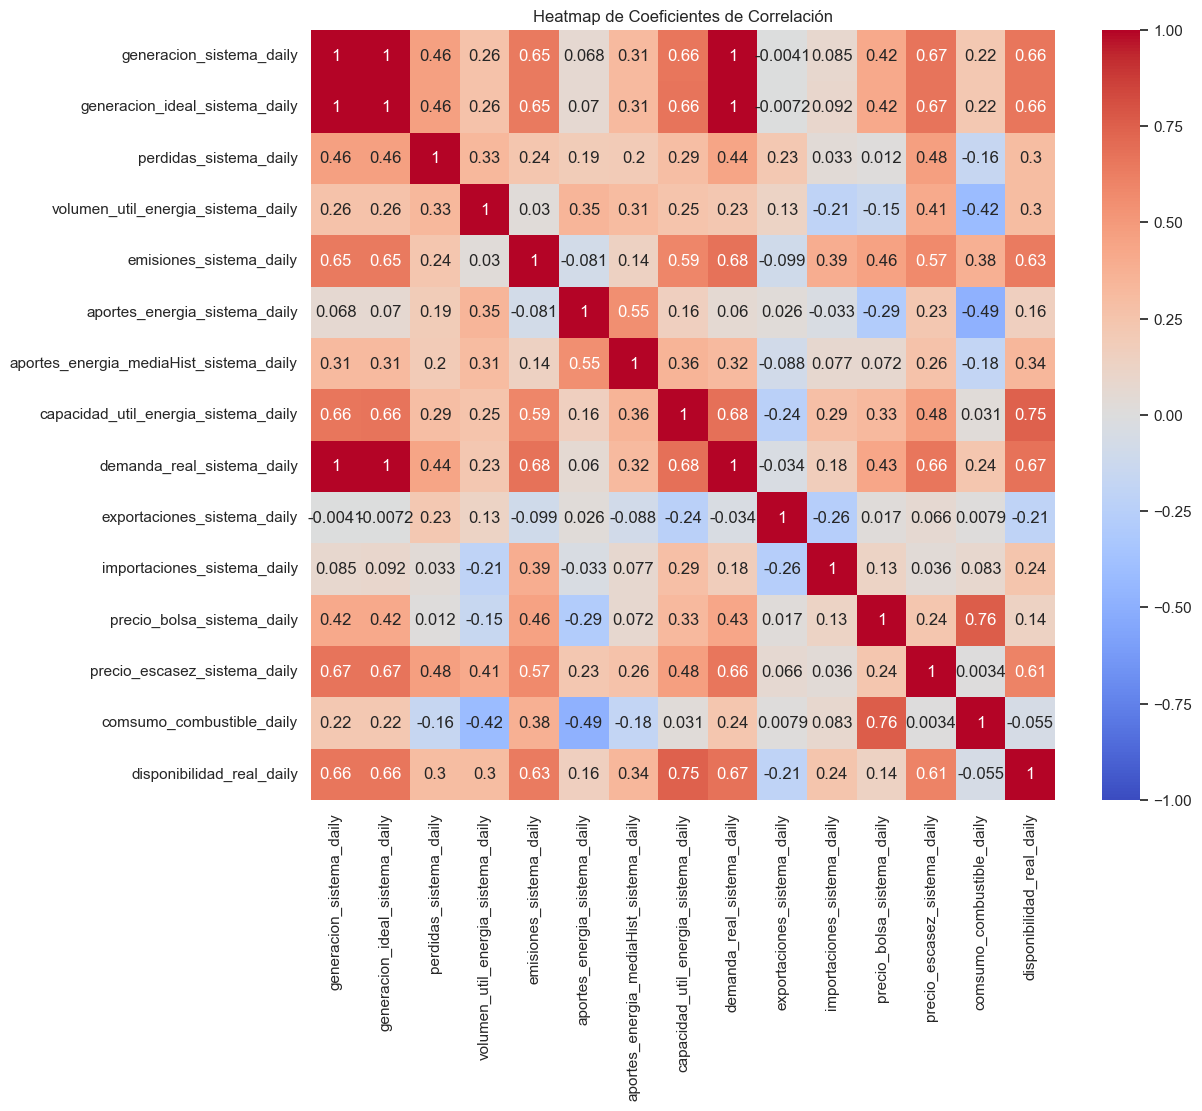

In [136]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
plt.title('Heatmap de Coeficientes de Correlación')
plt.show()

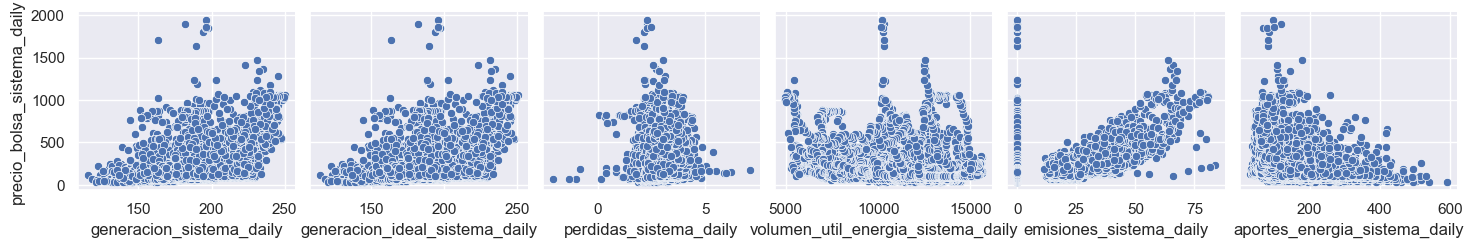

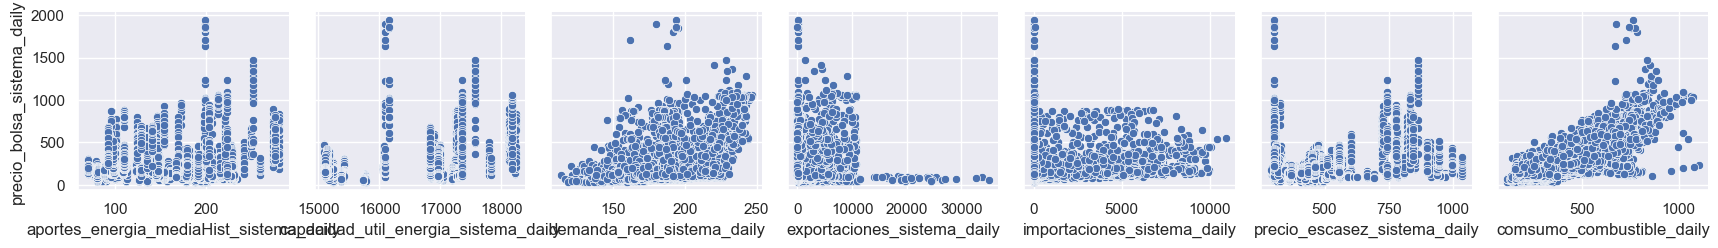

In [137]:

y_vars = ['precio_bolsa_sistema_daily']

x_vars = ['generacion_sistema_daily', 
          'generacion_ideal_sistema_daily',
          'perdidas_sistema_daily',
          'volumen_util_energia_sistema_daily',
          'emisiones_sistema_daily',
          'aportes_energia_sistema_daily']

sns.pairplot(df_sistema_electrico_converted, y_vars=y_vars, x_vars=x_vars)
x_vars = ['aportes_energia_mediaHist_sistema_daily',
          'capacidad_util_energia_sistema_daily',
          'demanda_real_sistema_daily',
          'exportaciones_sistema_daily',
          'importaciones_sistema_daily',
          'precio_escasez_sistema_daily',
          'comsumo_combustible_daily']
sns.pairplot(df_sistema_electrico_converted, y_vars=y_vars, x_vars=x_vars)

## Seleccion de Variables

La variable `generacion_ideal_sistema_daily` es casi idéntica a `generacion_sistema_daily`. Esto se debe a que la definición de generación ideal se basa en contar la energía sin tener en cuenta las pérdidas por transporte. Dado que ambas variables contienen prácticamente la misma información, se puede eliminar una de ellas. Eliminaremos `generacion_ideal_sistema_daily`:

In [138]:
df_sistema_electrico_converted = df_sistema_electrico_converted.drop('generacion_ideal_sistema_daily', axis=1)
df_sistema_electrico_converted.columns

Index(['generacion_sistema_daily', 'perdidas_sistema_daily',
       'volumen_util_energia_sistema_daily', 'emisiones_sistema_daily',
       'aportes_energia_sistema_daily',
       'aportes_energia_mediaHist_sistema_daily',
       'capacidad_util_energia_sistema_daily', 'demanda_real_sistema_daily',
       'exportaciones_sistema_daily', 'importaciones_sistema_daily',
       'precio_bolsa_sistema_daily', 'precio_escasez_sistema_daily',
       'comsumo_combustible_daily', 'disponibilidad_real_daily'],
      dtype='object')

Las variables `aportes_energia_mediaHist_sistema_daily`, `capacidad_util_energia_sistema_daily` y `precio_escasez_sistema_daily` son variables de diseño del sistema o  que se definen como referencia para toma de desiciones y no depende de la variabilidad de la operación horaria del sistema. Por lo tanto las eliminaremos de este analisis:

In [139]:
df_sistema_electrico_converted = df_sistema_electrico_converted.drop(['aportes_energia_mediaHist_sistema_daily', 
                                                                     'capacidad_util_energia_sistema_daily', 
                                                                     'precio_escasez_sistema_daily'], 
                                                                     axis=1)
df_sistema_electrico_converted.columns

Index(['generacion_sistema_daily', 'perdidas_sistema_daily',
       'volumen_util_energia_sistema_daily', 'emisiones_sistema_daily',
       'aportes_energia_sistema_daily', 'demanda_real_sistema_daily',
       'exportaciones_sistema_daily', 'importaciones_sistema_daily',
       'precio_bolsa_sistema_daily', 'comsumo_combustible_daily',
       'disponibilidad_real_daily'],
      dtype='object')

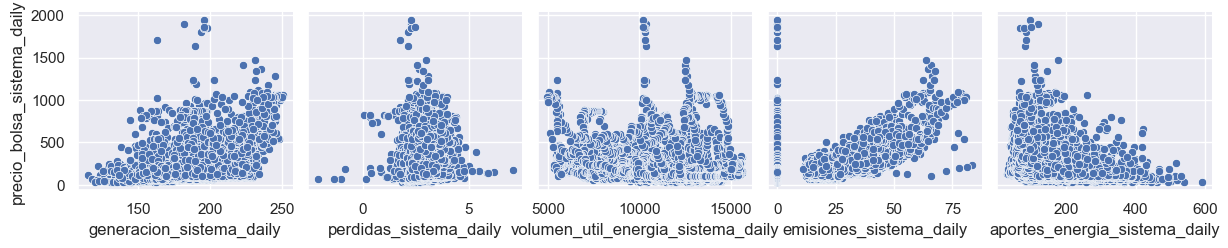

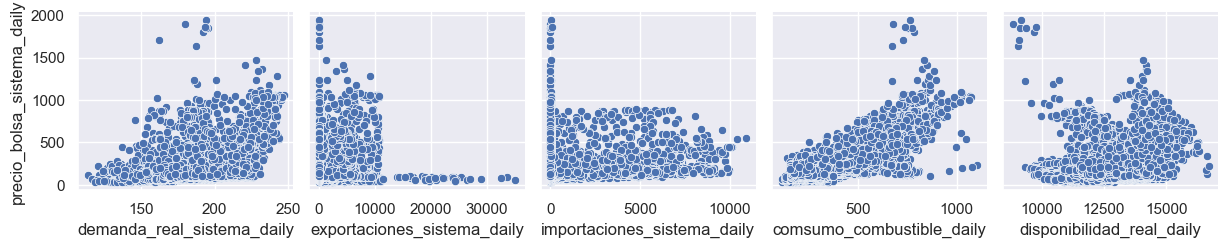

In [140]:
y_vars = ['precio_bolsa_sistema_daily']

x_vars = ['generacion_sistema_daily', 

          'perdidas_sistema_daily',
          'volumen_util_energia_sistema_daily',
          'emisiones_sistema_daily',
          'aportes_energia_sistema_daily']

sns.pairplot(df_sistema_electrico_converted, y_vars=y_vars, x_vars=x_vars)
x_vars = [

          'demanda_real_sistema_daily',
          'exportaciones_sistema_daily',
          'importaciones_sistema_daily',
          'comsumo_combustible_daily',
          'disponibilidad_real_daily']
sns.pairplot(df_sistema_electrico_converted, y_vars=y_vars, x_vars=x_vars)

In [141]:
df_sistema_electrico_converted.to_csv('./data/df_sistema_electrico_ML.csv')

Con estas variables se construira un modelo de Machine Learning para predecir el precio bolsa con las variables operativas del sistema.